In [80]:
from utils import load_data_from_csv, c_index
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image 
import pydotplus

# Load dataset

In [81]:
X_train_org, X_test, y_train_org, y_test = load_data_from_csv(threshold=10, test_size=0.2)

In [82]:
print("X_train shape:", X_train_org.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6863, 18)
X_test shape: (1716, 18)


Split to X_train / X_val (75% - 25% of X_train data)

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X_train_org, y_train_org, test_size=0.25, random_state=42)

In [84]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5147, 18)
X_val shape: (1716, 18)
X_test shape: (1716, 18)


Show information of X_train

In [85]:
X_train.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
8559,67.0,88.0,351.0,1.0,48.5,7.0,4.1,227.0,152.0,1.52,6.6,1.0,156.0,326.0,46.6,9.8,31.267452,68.0
7348,34.0,100.0,999.0,2.0,44.4,19.0,3.7,297.0,143.0,1.86,6.8,1.0,150.0,399.0,35.8,5.6,25.113065,50.0
5056,39.0,94.0,999.0,1.0,49.7,11.0,4.3,213.0,62.0,1.68,7.4,1.0,158.0,343.0,18.1,8.6,26.533553,64.0
3655,39.0,85.0,59.0,1.0,49.2,23.0,4.5,235.0,61.0,1.67,7.4,2.0,130.0,319.0,19.1,9.8,32.807368,45.0
2048,33.0,82.0,168.0,2.0,77.7,31.0,4.7,275.0,75.0,1.90,7.9,1.0,126.0,320.0,23.4,9.4,30.366643,44.0


Get random sample of X_train 

In [86]:
random_index = random.randint(0, len(X_train))

In [87]:
print(X_train.iloc[random_index, :])
print("Label: ", y_train.loc[y_train.index[random_index]])

Age                    56.000000
Diastolic BP           98.000000
Poverty index         351.000000
Race                    1.000000
Red blood cells        47.000000
Sedimentation rate     10.000000
Serum Albumin           4.300000
Serum Cholesterol     282.000000
Serum Iron             73.000000
Serum Magnesium         1.680000
Serum Protein           6.500000
Sex                     1.000000
Systolic BP           130.000000
TIBC                  308.000000
TS                     23.700000
White blood cells       6.900000
BMI                    26.970957
Pulse pressure         32.000000
Name: 9371, dtype: float64
Label:  False


# Check Data

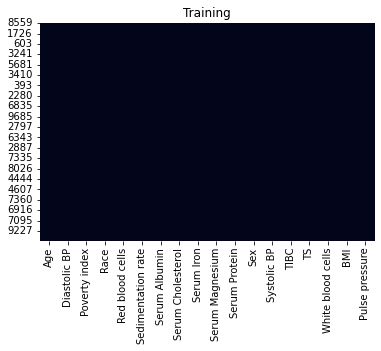

In [88]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

# Decision Trees

Without max_depth and min_samples_split

In [89]:
dt_with_out_max_depth = DecisionTreeClassifier(max_depth=None, random_state=42)
dt_with_out_max_depth.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [90]:
y_train_preds = dt_with_out_max_depth.predict_proba(X_train)[:, 1]
y_val_preds = dt_with_out_max_depth.predict_proba(X_val)[:, 1]

In [91]:
print("Train accuracy: ", c_index(y_train.values, y_train_preds))
print("Val accuracy: ", c_index(y_val.values, y_val_preds))
print("Test accuracy: ", c_index(y_test.values, dt_with_out_max_depth.predict_proba(X_test)[:, 1]))

Train accuracy:  1.0
Val accuracy:  0.5858987700932962
Test accuracy:  0.5863798424861644


In [92]:
y_train_preds

array([0., 0., 0., ..., 1., 0., 0.])

### Change hyper parameters to get better result

In [93]:
decision_tree_hyperparams = {
    'max_depth': 3,
}

In [94]:
decision_tree_with_max_depth = DecisionTreeClassifier(**decision_tree_hyperparams, random_state=42)
decision_tree_with_max_depth.fit(X_train, y_train)

# validation
y_train_preds = decision_tree_with_max_depth.predict_proba(X_train)[:, 1]
y_val_preds = decision_tree_with_max_depth.predict_proba(X_val)[:, 1]

# print
print("Train accuracy: ", c_index(y_train.values, y_train_preds))
print("Val accuracy: ", c_index(y_val.values, y_val_preds))

Train accuracy:  0.7400761530771275
Val accuracy:  0.7249208109505191


In [95]:
# plot tree
# tree.plot_tree(decision_tree_with_max_depth)

### Visualize the tree

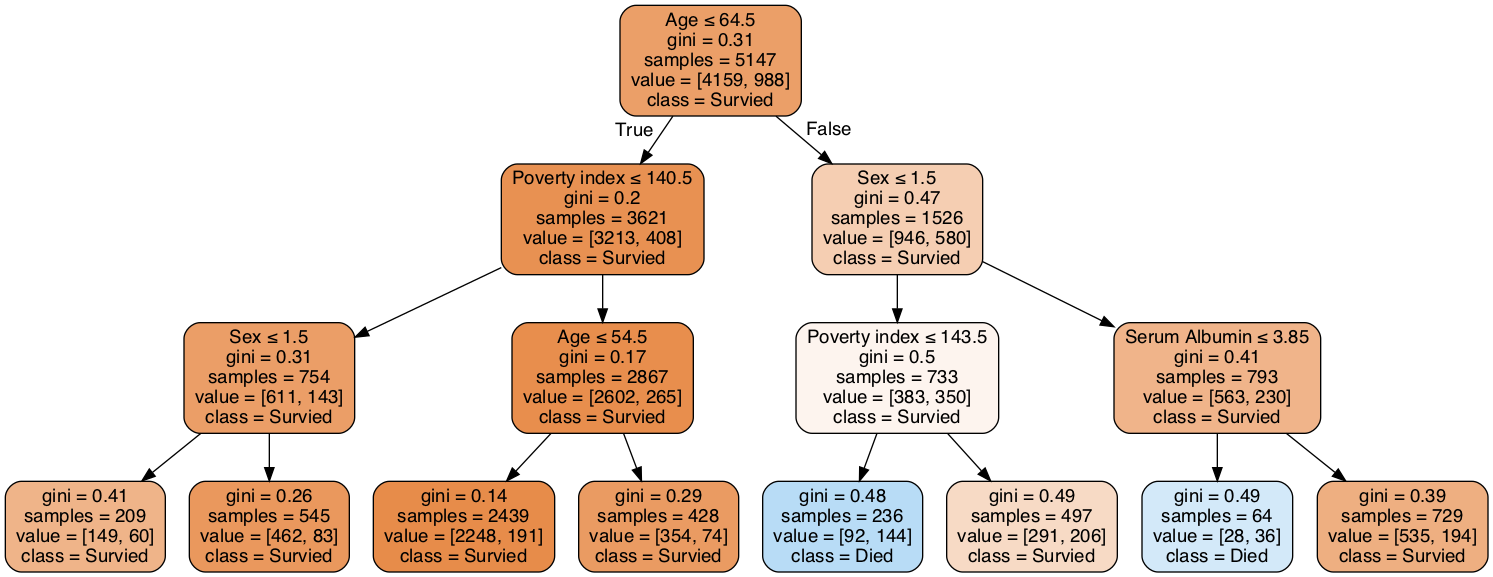

In [96]:
dot_data = StringIO()
export_graphviz(decision_tree_with_max_depth, feature_names=X_train.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=False, special_characters=True,
                impurity=True, class_names=['Survied', 'Died'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Grid Search Tree

In [97]:
import itertools

def grid_search(tree, X_train, y_train, X_val, y_val, hyperparams, fixed_hyperparams={}):
    best_estimator = None
    best_hyperparams = {}
    
    best_score = 0.0
    lists = hyperparams.values()
    
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)


    for i, params in enumerate(param_combinations, 1):
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = tree(**param_dict, **fixed_hyperparams)
        estimator.fit(X_train, y_train)
        
        preds = estimator.predict_proba(X_val)
        
        # compute cindex for predictions
        estimator_score = c_index(y_val, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # update and get best hyperparams
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    best_hyperparams.update(fixed_hyperparams)
    return best_estimator, best_hyperparams, best_score

In [98]:
decision_tree_hyperparams = {
    'max_depth': [None, 3, 5, 10, 50, 100],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
}
fixed_hyperparams = {
        'random_state': 42,
}

In [99]:
tree = DecisionTreeClassifier

In [100]:
best_estimator, best_hyperparams,best_score = grid_search(tree, X_train, y_train, X_val, y_val, decision_tree_hyperparams, fixed_hyperparams)

[1/216] {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
Val C-Index: 0.5858987700932962

[2/216] {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5}
Val C-Index: 0.6136644661485315

[3/216] {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10}
Val C-Index: 0.6572861895664015

[4/216] {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 20}
Val C-Index: 0.6661102748787969

[5/216] {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 50}
Val C-Index: 0.6940182948906838

[6/216] {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 100}
Val C-Index: 0.7010821175072129

[7/216] {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}
Val C-Index: 0.5921314208029804

[8/216] {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5}
Val C-Index: 0.6136644661485315

[9/216] {'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 10}
Val C-Index: 0.6572861895664015

[10/216] {'max_depth':

In [101]:
best_score

0.7249208109505191

In [102]:
best_hyperparams

{'max_depth': 3,
 'min_samples_split': 100,
 'min_samples_leaf': 50,
 'random_state': 42}

In [110]:
# evaluate on train 
y_train_preds = best_estimator.predict_proba(X_train)[:, 1]
print("Train accuracy: ", c_index(y_train.values, y_train_preds))

Train accuracy:  0.7400761530771275


In [109]:
# evaluate on test set 
y_test_preds = best_estimator.predict_proba(X_test)[:, 1]
print("Test accuracy: ", c_index(y_test.values, y_test_preds))

Test accuracy:  0.731555759543068


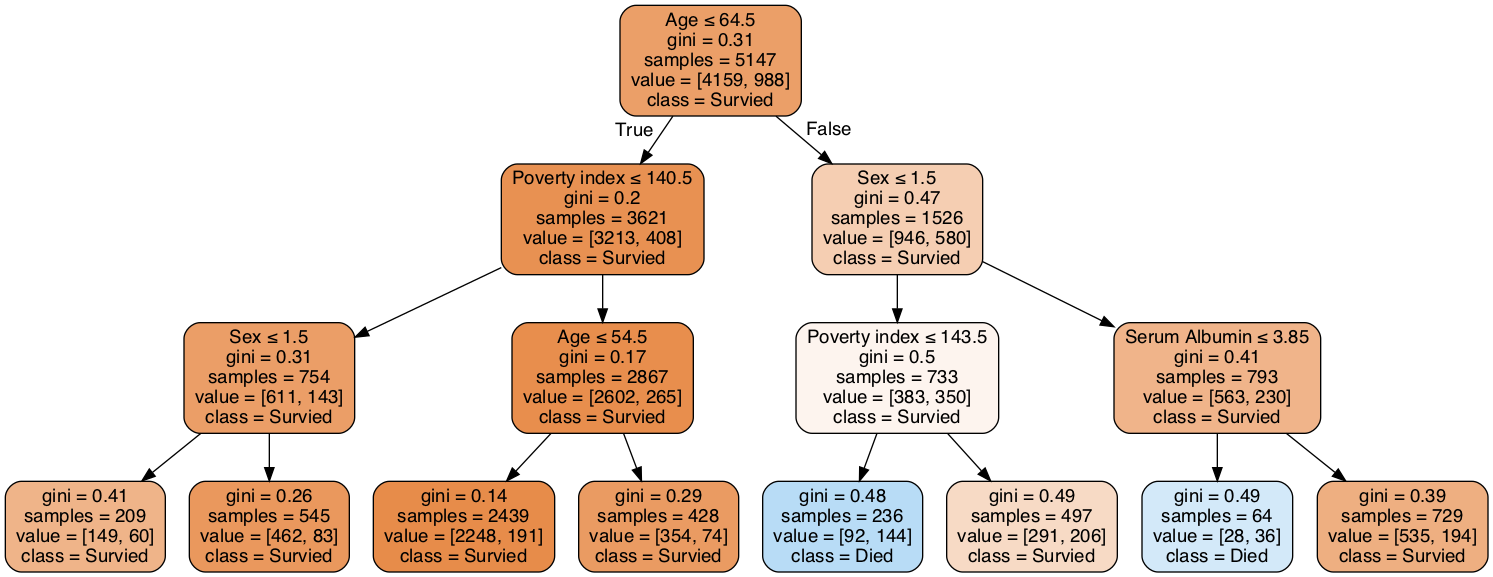

In [103]:
dot_data = StringIO()
export_graphviz(best_estimator, feature_names=X_train.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=False, special_characters=True,
                impurity=True, class_names=['Survied', 'Died'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Explain tree 

In [104]:
import shap

In [105]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = best_estimator.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
5543,65.0,80.0,96.0,1.0,77.7,6.0,4.3,165.0,101.0,1.72,7.2,1.0,112.0,374.0,27.0,9.5,19.907902,32.0,0.610169
906,72.0,50.0,98.0,1.0,39.9,38.0,4.8,117.0,87.0,1.90,7.8,1.0,140.0,307.0,28.3,6.5,24.424939,90.0,0.610169
329,70.0,96.0,73.0,1.0,77.7,16.0,4.4,172.0,134.0,1.72,7.4,1.0,170.0,326.0,41.1,5.2,25.421987,74.0,0.610169
6353,70.0,100.0,76.0,1.0,77.7,2.0,4.1,198.0,56.0,1.64,7.3,1.0,170.0,544.0,10.3,7.3,19.921943,70.0,0.610169
5828,67.0,96.0,110.0,1.0,52.0,19.0,4.4,287.0,128.0,1.68,6.7,1.0,164.0,319.0,40.1,7.2,24.463320,68.0,0.610169


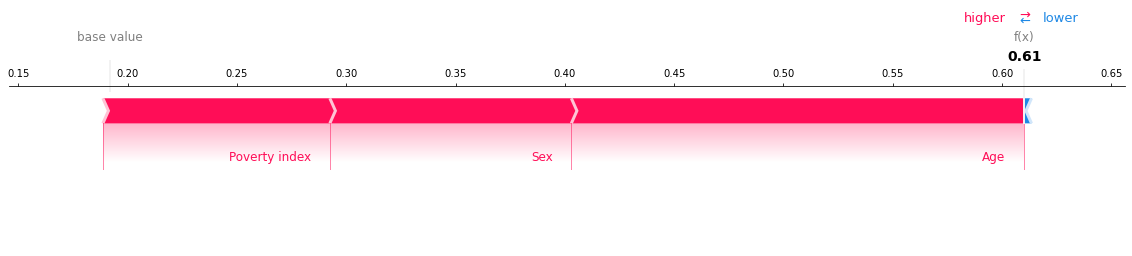

In [106]:

explainer = shap.TreeExplainer(best_estimator)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

In [107]:
shap_values = shap.TreeExplainer(best_estimator).shap_values(X_test)[1]

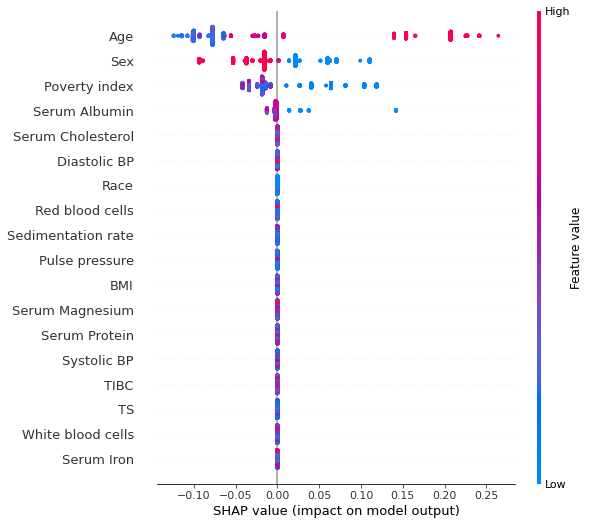

In [108]:
shap.summary_plot(shap_values, X_test)